In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

# Birth & Death

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
special_probs = {"birth": 0.5, "death": 0.5}
#special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

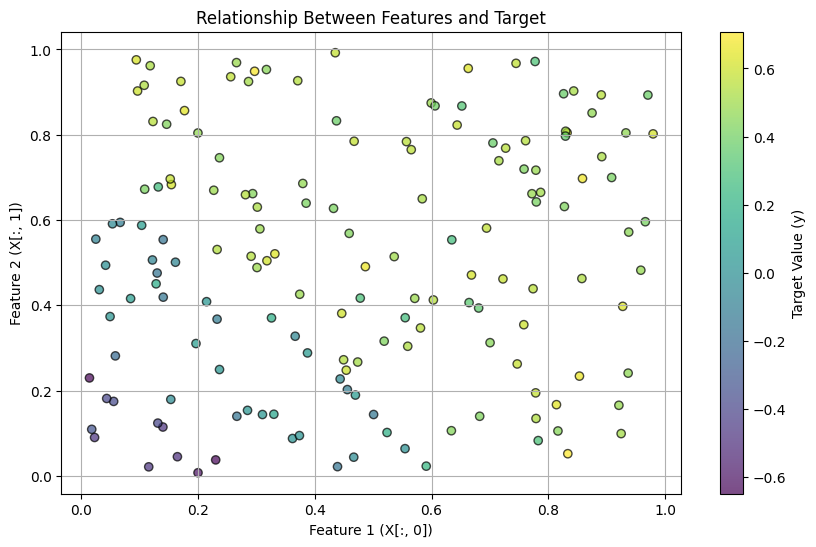

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
n_trees_ini = 50
#temperature = TemperatureSchedule(lambda t: max(0.1, 1 - t/1000))
temperature = 1.0
bart = ChangeNumTreeBART(ndpost=10000, nskip=20000, n_trees=n_trees_ini, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0_ini = n_trees_ini, theta_0_min = 10, theta_df = 100, temperature=temperature,
                         tree_num_prior_type="poisson", special_move_interval=5)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 30000/30000 [03:03<00:00, 163.72it/s]


In [5]:
bart.trace[-1].n_trees

28

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.01039288]), 'ntree_theta': 14.564821803556983}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

26.453

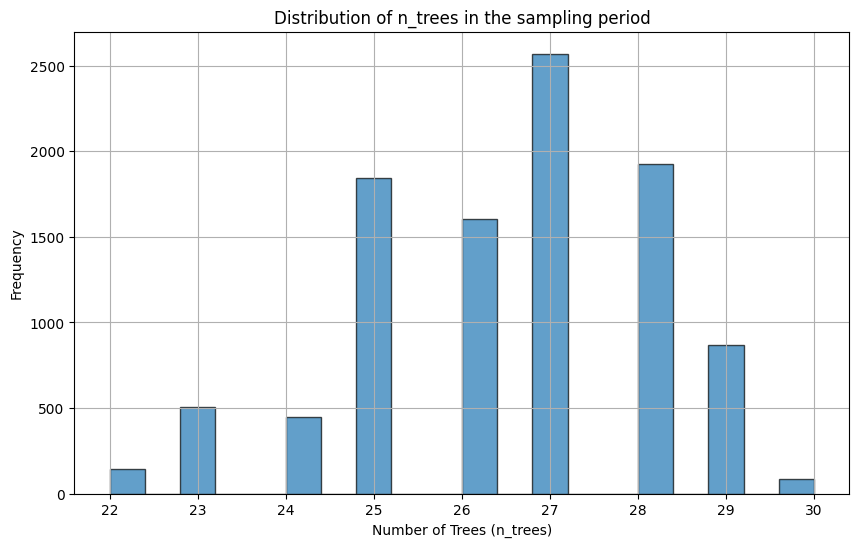

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

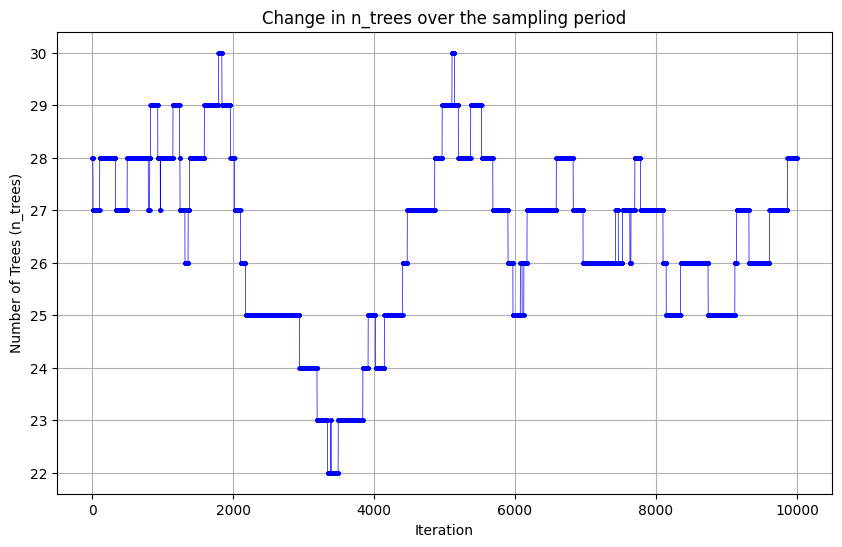

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
# Extract ntree_theta from global_params for each trace
ntree_theta_list = [trace.global_params['ntree_theta'] for trace in bart.trace]
np.mean(ntree_theta_list)

12.75557498404839

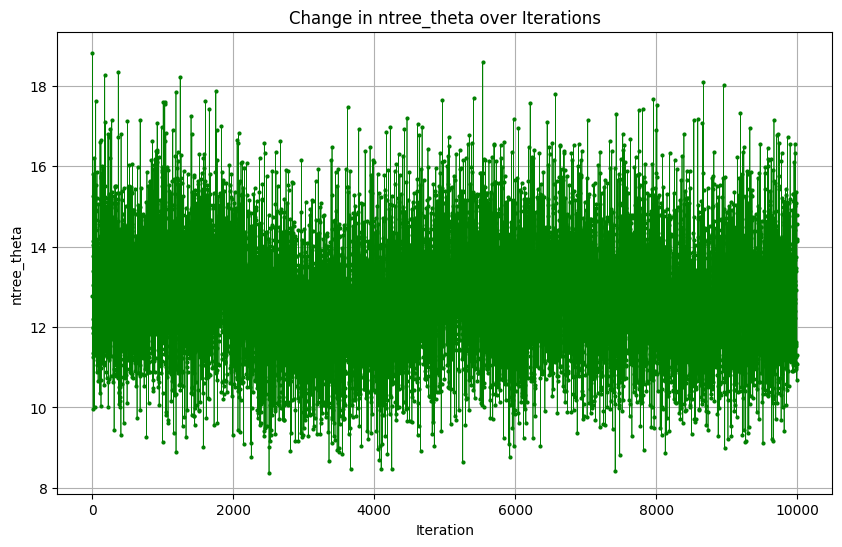

In [11]:
# Plot ntree_theta over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(ntree_theta_list)), ntree_theta_list, marker='o', markersize=2, linestyle='-', linewidth=0.5, color='g')
plt.title('Change in ntree_theta over Iterations')
plt.xlabel('Iteration')
plt.ylabel('ntree_theta')
plt.grid(True)
plt.show()

In [12]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 2987; mh median: 0.019757219167386667


In [13]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 136; mh median: 32.15710016953052


In [14]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-05-15 01:16:07,174:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-15 01:16:07,177:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.39 P_prune=0.61 A_grow=0.18 A_prune=0.29 (burnin)
Iteration 200/300 P_grow=0.68 P_prune=0.32 A_grow=0.11 A_prune=0.44
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.12 A_prune=0.25


In [15]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.021209906825313755,
 'rf': 0.024779912908543436,
 'lr': 0.048045521328019404,
 'btz': 0.0229335393148943}

In [16]:
bart.trace[-1].trees

[Tree(vars=[ 1  0 -1 -1 -1 -2 -2 -2], thresholds=[0.4545228  0.15854869        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan -0.00554838  0.08764822  0.03673027         nan
          nan         nan], n_vals=[120  53  67  10  43  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.11051175        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan -0.0300822   0.01023138         nan         nan         nan
          nan         nan], n_vals=[120  15 105  -2  -2  -2  -2  -2]),
 Tree(vars=[ 1 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.09119463        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan -0.00540991  0.03140904         nan         nan         nan
          nan         nan], n_vals=[120  10 110  -2  -2  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.92356431        nan        nan        nan        nan        

In [17]:
if all([(bart.sampler.trace[-1].trees[i].evaluate() == bart.sampler.trace[-1].trees[i].evaluate(X_train)).all()
            for i in range(bart.sampler.trace[-1].n_trees)]):
    print("True")
else:
    print("False")

True


In [18]:
np.allclose(bart.sampler.trace[-1].evaluate(X_train), bart.sampler.trace[-1].evaluate(), atol=1e-10, rtol=1e-12)

True

In [19]:
bart.sampler.trace[-1].evaluate()

array([ 0.28107676,  0.40343412,  0.17558968,  0.40817836,  0.38930933,
        0.32419473, -0.29931482,  0.42282011,  0.02067965,  0.16637766,
        0.20319661,  0.34829987,  0.45284509,  0.40343412,  0.31986833,
        0.30795459,  0.06757512,  0.32518534,  0.23100259,  0.36237432,
        0.21044161, -0.26193364,  0.38573096,  0.33573243,  0.32486993,
        0.40033981,  0.41636985,  0.29265923,  0.51024883,  0.47891604,
       -0.26193364,  0.36453506,  0.02726154,  0.11724501,  0.45376695,
        0.31363694,  0.32413611,  0.44626602, -0.29931482,  0.17360897,
        0.38962474,  0.39221225,  0.38305136,  0.03078303, -0.0784755 ,
        0.4145107 , -0.24931873,  0.27663113,  0.4318753 ,  0.16100775,
        0.40343412,  0.34602256,  0.40646487,  0.44263765,  0.31986833,
        0.06781115,  0.36143332,  0.33194462,  0.27663113,  0.23100259,
        0.44626602,  0.30174936,  0.35711708,  0.39088748,  0.05657202,
        0.41253151,  0.18902219,  0.16100775,  0.27418259,  0.08

In [20]:
bart.sampler.trace[-1].evaluate(X_train)

array([ 0.28107676,  0.40343412,  0.17558968,  0.40817836,  0.38930933,
        0.32419473, -0.29931482,  0.42282011,  0.02067965,  0.16637766,
        0.20319661,  0.34829987,  0.45284509,  0.40343412,  0.31986833,
        0.30795459,  0.06757512,  0.32518534,  0.23100259,  0.36237432,
        0.21044161, -0.26193364,  0.38573096,  0.33573243,  0.32486993,
        0.40033981,  0.41636985,  0.29265923,  0.51024883,  0.47891604,
       -0.26193364,  0.36453506,  0.02726154,  0.11724501,  0.45376695,
        0.31363694,  0.32413611,  0.44626602, -0.29931482,  0.17360897,
        0.38962474,  0.39221225,  0.38305136,  0.03078303, -0.0784755 ,
        0.4145107 , -0.24931873,  0.27663113,  0.4318753 ,  0.16100775,
        0.40343412,  0.34602256,  0.40646487,  0.44263765,  0.31986833,
        0.06781115,  0.36143332,  0.33194462,  0.27663113,  0.23100259,
        0.44626602,  0.30174936,  0.35711708,  0.39088748,  0.05657202,
        0.41253151,  0.18902219,  0.16100775,  0.27418259,  0.08